# Deep Learning Chat Bot with Python and Keras

Multiclass classification using the Keras deep learning frame work. The model is trained on input phrases and classifies input into one of a few differnt output classes for which a response back to the user is chosen.


# TODO:

>Print loss data and accuracy, to show how well model is doing. 

>Pass validation data

>K-fold cross validation or iterated k-fold, for small data sets

>Trying different optimizer and output.

In [2]:
import keras
keras.__version__

'2.4.3'

In [3]:
import nltk
import numpy as np
import json
import random
import pickle

from nltk.stem.lancaster import LancasterStemmer
stemmer = LancasterStemmer()  

In [4]:
# Load data from Json file
jsonFile = open('intents_FR.json')
fileData = json.load(jsonFile)

## Generate training data
Extract data from json file to be vectorized into the form of tensors so it can be input into NN.
Do the full process of readng from json file, tokenizing words, and doing one-hot encoding.

patterns = potential inputs to the bot

In [5]:
# Blank lists for extracting data from JSON file
words = []
labels = []
docs_x = []  # Store each pattern
docs_y = []  # Also keep track of what 'tag' they belong to 

##################### DATA PRE-PROCESSING #####################
for intent in fileData["intents"]:
    for pattern in intent["patterns"]:
        cur_words = nltk.word_tokenize(pattern)  # Tokenize each pattern into words 
        words.extend(cur_words)                  # Extending list rather than looping and appending
        docs_x.append(cur_words)
        docs_y.append(intent["tag"])

    # New tag of input was added to training data
    if intent["tag"] not in labels: 
        labels.append(intent["tag"])

# "?" is a common thing for user to enter, but we dont want to have any meaning
words = [stemmer.stem(w.lower()) for w in words if w != "?"]  # Stem each word 

# 'sets' used to remove duplicates
words = sorted(list(set(words))) # Set gets converted back into a list 
labels = sorted(labels)          # Sort our labels as well


################### CREATE TRAINING AND TESTING OUTPUT ##############
# 'One hot encoded' list consisting of if a word excists or not
# This is NOT a true list of freq's simply '1' or '0' if excists

training = []
output = []

# Only one class will be '1' at a time indicating which tag to use 
out_empty = [0 for _ in range(len(labels))]  # Begin with a 0 for every class or 'tag'

# Remember docs_x is the each pattern
for x, doc in enumerate(docs_x):
    bag = []  # bag of words
    cur_words = [stemmer.stem(w) for w in doc]

    for w in words: 
        if w in cur_words: 
            bag.append(1)  # Word excists in the pattern
        else:
            bag.append(0)  # Doesn't excist in the pattern

    # Generate the output
    output_row = out_empty[:]  # Make a copy of out empty (cleaner than using a list )

    # Look in the labels list and see where tags are and set that value to 1 in our output row
    output_row[labels.index(docs_y[x])] = 1

    training.append(bag)
    output.append(output_row)

# Turn lists into NumPy arrays 
training = np.array(training)
output = np.array(output)

# Save generated lists to a pickle file
pickle_file = open("data.pickle", "wb")
pickle.dump((words, labels, training, output), pickle_file) 

In [7]:
training.shape

(18, 34)

## Building the model
Calls to the Keras API to construct our NN.
Hidden layers have 8 nodes each. Input and output shape size are not hardcoded, but rather found by getting the size of the input data from the json file as data is added to it.

In [18]:
from keras import models
from keras import layers

model = models.Sequential()
model.add(layers.Dense(8, activation='relu',input_shape=(len(training[0]),)))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(len(output[0]), activation='softmax'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 8)                 280       
_________________________________________________________________
dense_4 (Dense)              (None, 8)                 72        
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 45        
Total params: 397
Trainable params: 397
Non-trainable params: 0
_________________________________________________________________


## Compiling the model
Input the loss metrics we are trying to analyze

In [9]:
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

## Training the model
Using 1000 epochs on batch sizes of 8 becase we have a small data set for deeep learning

### K-fold validation
Especially good for small data sets

In [1]:
"""
k = 4
num_valid_samples = len(training) // k

np.random.shuffle(training)

valid_scores = []
for fold in range(k):
    # Select the validation partition
    valid_data = training[num_valid_samples * fold : num_valid_samples * (fold + 1)]
    
    # Use the remainder of data as training data
    training_data = training[:num_valid_samples * fold] + training[num_valid_samples * (fold + 1)]
    
    # Create a new instance of the model (untrained)
    #model = get_model()
    model.training(training_data)
    valid_score = model.evaluate(valid_data)
    valid_scores.append(valid_score)
    
# Validation score: average of the validation scores of k folds
valid_score = np.average(valid_scores)

# Train the final model on all test data available
#model = get_model()
model.train(training)
test_score = model.evaluate(test_data)
"""

'\nk = 4\nnum_valid_samples = len(training) // k\n\nnp.random.shuffle(training)\n\nvalid_scores = []\nfor fold in range(k):\n    # Select the validation partition\n    valid_data = training[num_valid_samples * fold : num_valid_samples * (fold + 1)]\n    \n    # Use the remainder of data as training data\n    training_data = training[:num_valid_samples * fold] + training[num_valid_samples * (fold + 1)]\n    \n    # Create a new instance of the model (untrained)\n    #model = get_model()\n    model.training(training_data)\n    valid_score = model.evaluate(valid_data)\n    valid_scores.append(valid_score)\n    \n# Validation score: average of the validation scores of k folds\nvalid_score = np.average(valid_scores)\n\n# Train the final model on all test data available\n#model = get_model()\nmodel.train(training)\ntest_score = model.evaluate(test_data)\n'

In [10]:
# Create a validation set from our training data
x_val = training[:10]
partial_x_train = training[10:]

y_val = output[:10]
partial_y_train = output[10:]


history = model.fit(training,
                    output,
                    epochs=1000,
                    batch_size=8,
                    validation_data=(x_val, y_val))
                

Epoch 1/1000
3/3 [==============================] - 0s 46ms/step - loss: 1.6132 - accuracy: 0.1111 - val_loss: 1.6325 - val_accuracy: 0.0000e+00
Epoch 2/1000
3/3 [==============================] - 0s 7ms/step - loss: 1.5993 - accuracy: 0.1111 - val_loss: 1.6225 - val_accuracy: 0.0000e+00
Epoch 3/1000
3/3 [==============================] - 0s 12ms/step - loss: 1.5893 - accuracy: 0.1667 - val_loss: 1.6152 - val_accuracy: 0.0000e+00
Epoch 4/1000
3/3 [==============================] - 0s 7ms/step - loss: 1.5817 - accuracy: 0.1667 - val_loss: 1.6090 - val_accuracy: 0.0000e+00
Epoch 5/1000
3/3 [==============================] - 0s 10ms/step - loss: 1.5747 - accuracy: 0.1667 - val_loss: 1.6023 - val_accuracy: 0.0000e+00
Epoch 6/1000
3/3 [==============================] - 0s 7ms/step - loss: 1.5691 - accuracy: 0.1667 - val_loss: 1.5989 - val_accuracy: 0.0000e+00
Epoch 7/1000
3/3 [==============================] - 0s 7ms/step - loss: 1.5632 - accuracy: 0.1667 - val_loss: 1.5934 - val_accuracy: 

Epoch 59/1000
3/3 [==============================] - 0s 6ms/step - loss: 1.2908 - accuracy: 0.5000 - val_loss: 1.3534 - val_accuracy: 0.4000
Epoch 60/1000
3/3 [==============================] - 0s 8ms/step - loss: 1.2840 - accuracy: 0.5000 - val_loss: 1.3463 - val_accuracy: 0.4000
Epoch 61/1000
3/3 [==============================] - 0s 6ms/step - loss: 1.2784 - accuracy: 0.5000 - val_loss: 1.3418 - val_accuracy: 0.4000
Epoch 62/1000
3/3 [==============================] - 0s 7ms/step - loss: 1.2739 - accuracy: 0.5000 - val_loss: 1.3396 - val_accuracy: 0.4000
Epoch 63/1000
3/3 [==============================] - 0s 8ms/step - loss: 1.2672 - accuracy: 0.5556 - val_loss: 1.3364 - val_accuracy: 0.4000
Epoch 64/1000
3/3 [==============================] - 0s 9ms/step - loss: 1.2622 - accuracy: 0.5000 - val_loss: 1.3316 - val_accuracy: 0.4000
Epoch 65/1000
3/3 [==============================] - 0s 7ms/step - loss: 1.2584 - accuracy: 0.5000 - val_loss: 1.3282 - val_accuracy: 0.5000
Epoch 66/1000

Epoch 117/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.9917 - accuracy: 0.7222 - val_loss: 1.1068 - val_accuracy: 0.8000
Epoch 118/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.9868 - accuracy: 0.7222 - val_loss: 1.1008 - val_accuracy: 0.8000
Epoch 119/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.9824 - accuracy: 0.7222 - val_loss: 1.0977 - val_accuracy: 0.8000
Epoch 120/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.9775 - accuracy: 0.7222 - val_loss: 1.0950 - val_accuracy: 0.8000
Epoch 121/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.9739 - accuracy: 0.7222 - val_loss: 1.0910 - val_accuracy: 0.8000
Epoch 122/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.9685 - accuracy: 0.7222 - val_loss: 1.0863 - val_accuracy: 0.8000
Epoch 123/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.9649 - accuracy: 0.7222 - val_loss: 1.0813 - val_accuracy: 0.8000
Epoch

Epoch 175/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.7473 - accuracy: 0.8333 - val_loss: 0.8485 - val_accuracy: 1.0000
Epoch 176/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.7439 - accuracy: 0.8333 - val_loss: 0.8480 - val_accuracy: 1.0000
Epoch 177/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.7408 - accuracy: 0.8333 - val_loss: 0.8463 - val_accuracy: 1.0000
Epoch 178/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.7364 - accuracy: 0.8333 - val_loss: 0.8394 - val_accuracy: 1.0000
Epoch 179/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.7338 - accuracy: 0.8333 - val_loss: 0.8373 - val_accuracy: 1.0000
Epoch 180/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.7298 - accuracy: 0.8333 - val_loss: 0.8337 - val_accuracy: 1.0000
Epoch 181/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.7265 - accuracy: 0.8333 - val_loss: 0.8325 - val_accuracy: 1.0000
Epoch 

3/3 [==============================] - 0s 8ms/step - loss: 0.5585 - accuracy: 1.0000 - val_loss: 0.6595 - val_accuracy: 1.0000
Epoch 233/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.5552 - accuracy: 1.0000 - val_loss: 0.6569 - val_accuracy: 1.0000
Epoch 234/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.5521 - accuracy: 1.0000 - val_loss: 0.6545 - val_accuracy: 1.0000
Epoch 235/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.5490 - accuracy: 1.0000 - val_loss: 0.6534 - val_accuracy: 1.0000
Epoch 236/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.5460 - accuracy: 1.0000 - val_loss: 0.6456 - val_accuracy: 1.0000
Epoch 237/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.5428 - accuracy: 1.0000 - val_loss: 0.6423 - val_accuracy: 1.0000
Epoch 238/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.5393 - accuracy: 1.0000 - val_loss: 0.6359 - val_accuracy: 1.0000
Epoch 239/1000
3/3 [=

3/3 [==============================] - 0s 7ms/step - loss: 0.3827 - accuracy: 1.0000 - val_loss: 0.4717 - val_accuracy: 1.0000
Epoch 290/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.3809 - accuracy: 1.0000 - val_loss: 0.4660 - val_accuracy: 1.0000
Epoch 291/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.3778 - accuracy: 1.0000 - val_loss: 0.4669 - val_accuracy: 1.0000
Epoch 292/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.3745 - accuracy: 1.0000 - val_loss: 0.4614 - val_accuracy: 1.0000
Epoch 293/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.3719 - accuracy: 1.0000 - val_loss: 0.4572 - val_accuracy: 1.0000
Epoch 294/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.3690 - accuracy: 1.0000 - val_loss: 0.4545 - val_accuracy: 1.0000
Epoch 295/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.3660 - accuracy: 1.0000 - val_loss: 0.4498 - val_accuracy: 1.0000
Epoch 296/1000
3/3 [=

Epoch 347/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.2274 - accuracy: 1.0000 - val_loss: 0.2932 - val_accuracy: 1.0000
Epoch 348/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.2245 - accuracy: 1.0000 - val_loss: 0.2895 - val_accuracy: 1.0000
Epoch 349/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.2225 - accuracy: 1.0000 - val_loss: 0.2860 - val_accuracy: 1.0000
Epoch 350/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.2194 - accuracy: 1.0000 - val_loss: 0.2816 - val_accuracy: 1.0000
Epoch 351/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.2165 - accuracy: 1.0000 - val_loss: 0.2799 - val_accuracy: 1.0000
Epoch 352/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.2139 - accuracy: 1.0000 - val_loss: 0.2759 - val_accuracy: 1.0000
Epoch 353/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.2113 - accuracy: 1.0000 - val_loss: 0.2729 - val_accuracy: 1.0000
Epoch 

3/3 [==============================] - 0s 7ms/step - loss: 0.1052 - accuracy: 1.0000 - val_loss: 0.1358 - val_accuracy: 1.0000
Epoch 405/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.1034 - accuracy: 1.0000 - val_loss: 0.1325 - val_accuracy: 1.0000
Epoch 406/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.1011 - accuracy: 1.0000 - val_loss: 0.1307 - val_accuracy: 1.0000
Epoch 407/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0996 - accuracy: 1.0000 - val_loss: 0.1284 - val_accuracy: 1.0000
Epoch 408/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0977 - accuracy: 1.0000 - val_loss: 0.1260 - val_accuracy: 1.0000
Epoch 409/1000
3/3 [==============================] - 0s 10ms/step - loss: 0.0958 - accuracy: 1.0000 - val_loss: 0.1238 - val_accuracy: 1.0000
Epoch 410/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0942 - accuracy: 1.0000 - val_loss: 0.1222 - val_accuracy: 1.0000
Epoch 411/1000
3/3 [

Epoch 462/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0319 - accuracy: 1.0000 - val_loss: 0.0371 - val_accuracy: 1.0000
Epoch 463/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0309 - accuracy: 1.0000 - val_loss: 0.0362 - val_accuracy: 1.0000
Epoch 464/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0300 - accuracy: 1.0000 - val_loss: 0.0354 - val_accuracy: 1.0000
Epoch 465/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0293 - accuracy: 1.0000 - val_loss: 0.0343 - val_accuracy: 1.0000
Epoch 466/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0286 - accuracy: 1.0000 - val_loss: 0.0328 - val_accuracy: 1.0000
Epoch 467/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0276 - accuracy: 1.0000 - val_loss: 0.0315 - val_accuracy: 1.0000
Epoch 468/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0267 - accuracy: 1.0000 - val_loss: 0.0302 - val_accuracy: 1.0000
Epoch 

Epoch 520/1000
3/3 [==============================] - 0s 11ms/step - loss: 0.0052 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 521/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0050 - accuracy: 1.0000 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 522/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0040 - val_accuracy: 1.0000
Epoch 523/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0046 - accuracy: 1.0000 - val_loss: 0.0039 - val_accuracy: 1.0000
Epoch 524/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0044 - accuracy: 1.0000 - val_loss: 0.0038 - val_accuracy: 1.0000
Epoch 525/1000
3/3 [==============================] - 0s 9ms/step - loss: 0.0043 - accuracy: 1.0000 - val_loss: 0.0036 - val_accuracy: 1.0000
Epoch 526/1000
3/3 [==============================] - 0s 12ms/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0034 - val_accuracy: 1.0000
Epoc

Epoch 577/1000
3/3 [==============================] - 0s 8ms/step - loss: 7.2832e-04 - accuracy: 1.0000 - val_loss: 4.4348e-04 - val_accuracy: 1.0000
Epoch 578/1000
3/3 [==============================] - 0s 8ms/step - loss: 7.0150e-04 - accuracy: 1.0000 - val_loss: 4.4085e-04 - val_accuracy: 1.0000
Epoch 579/1000
3/3 [==============================] - 0s 7ms/step - loss: 6.7305e-04 - accuracy: 1.0000 - val_loss: 4.2027e-04 - val_accuracy: 1.0000
Epoch 580/1000
3/3 [==============================] - 0s 6ms/step - loss: 6.4514e-04 - accuracy: 1.0000 - val_loss: 3.9814e-04 - val_accuracy: 1.0000
Epoch 581/1000
3/3 [==============================] - 0s 7ms/step - loss: 6.1507e-04 - accuracy: 1.0000 - val_loss: 3.8102e-04 - val_accuracy: 1.0000
Epoch 582/1000
3/3 [==============================] - 0s 7ms/step - loss: 6.0114e-04 - accuracy: 1.0000 - val_loss: 3.6767e-04 - val_accuracy: 1.0000
Epoch 583/1000
3/3 [==============================] - 0s 8ms/step - loss: 5.7462e-04 - accuracy: 1.0

3/3 [==============================] - 0s 6ms/step - loss: 1.0625e-04 - accuracy: 1.0000 - val_loss: 5.7285e-05 - val_accuracy: 1.0000
Epoch 632/1000
3/3 [==============================] - 0s 7ms/step - loss: 1.0139e-04 - accuracy: 1.0000 - val_loss: 5.4961e-05 - val_accuracy: 1.0000
Epoch 633/1000
3/3 [==============================] - 0s 7ms/step - loss: 9.8342e-05 - accuracy: 1.0000 - val_loss: 5.3662e-05 - val_accuracy: 1.0000
Epoch 634/1000
3/3 [==============================] - 0s 7ms/step - loss: 9.3695e-05 - accuracy: 1.0000 - val_loss: 5.2208e-05 - val_accuracy: 1.0000
Epoch 635/1000
3/3 [==============================] - 0s 7ms/step - loss: 8.9743e-05 - accuracy: 1.0000 - val_loss: 4.9586e-05 - val_accuracy: 1.0000
Epoch 636/1000
3/3 [==============================] - 0s 8ms/step - loss: 8.6075e-05 - accuracy: 1.0000 - val_loss: 4.7345e-05 - val_accuracy: 1.0000
Epoch 637/1000
3/3 [==============================] - 0s 8ms/step - loss: 8.3738e-05 - accuracy: 1.0000 - val_loss:

Epoch 686/1000
3/3 [==============================] - 0s 7ms/step - loss: 1.2947e-05 - accuracy: 1.0000 - val_loss: 6.6875e-06 - val_accuracy: 1.0000
Epoch 687/1000
3/3 [==============================] - 0s 7ms/step - loss: 1.2643e-05 - accuracy: 1.0000 - val_loss: 6.3657e-06 - val_accuracy: 1.0000
Epoch 688/1000
3/3 [==============================] - 0s 9ms/step - loss: 1.2139e-05 - accuracy: 1.0000 - val_loss: 6.1869e-06 - val_accuracy: 1.0000
Epoch 689/1000
3/3 [==============================] - 0s 10ms/step - loss: 1.1636e-05 - accuracy: 1.0000 - val_loss: 6.1750e-06 - val_accuracy: 1.0000
Epoch 690/1000
3/3 [==============================] - 0s 8ms/step - loss: 1.1358e-05 - accuracy: 1.0000 - val_loss: 6.1511e-06 - val_accuracy: 1.0000
Epoch 691/1000
3/3 [==============================] - 0s 10ms/step - loss: 1.0808e-05 - accuracy: 1.0000 - val_loss: 5.8412e-06 - val_accuracy: 1.0000
Epoch 692/1000
3/3 [==============================] - 0s 8ms/step - loss: 1.0417e-05 - accuracy: 1

3/3 [==============================] - 0s 7ms/step - loss: 1.5563e-06 - accuracy: 1.0000 - val_loss: 6.9141e-07 - val_accuracy: 1.0000
Epoch 741/1000
3/3 [==============================] - 0s 8ms/step - loss: 1.4835e-06 - accuracy: 1.0000 - val_loss: 6.7949e-07 - val_accuracy: 1.0000
Epoch 742/1000
3/3 [==============================] - 0s 7ms/step - loss: 1.4371e-06 - accuracy: 1.0000 - val_loss: 6.6757e-07 - val_accuracy: 1.0000
Epoch 743/1000
3/3 [==============================] - 0s 6ms/step - loss: 1.4504e-06 - accuracy: 1.0000 - val_loss: 6.4373e-07 - val_accuracy: 1.0000
Epoch 744/1000
3/3 [==============================] - 0s 6ms/step - loss: 1.3312e-06 - accuracy: 1.0000 - val_loss: 5.7220e-07 - val_accuracy: 1.0000
Epoch 745/1000
3/3 [==============================] - 0s 8ms/step - loss: 1.2716e-06 - accuracy: 1.0000 - val_loss: 5.6028e-07 - val_accuracy: 1.0000
Epoch 746/1000
3/3 [==============================] - 0s 6ms/step - loss: 1.2384e-06 - accuracy: 1.0000 - val_loss:

Epoch 795/1000
3/3 [==============================] - 0s 8ms/step - loss: 1.9206e-07 - accuracy: 1.0000 - val_loss: 8.3446e-08 - val_accuracy: 1.0000
Epoch 796/1000
3/3 [==============================] - 0s 9ms/step - loss: 1.8544e-07 - accuracy: 1.0000 - val_loss: 8.3446e-08 - val_accuracy: 1.0000
Epoch 797/1000
3/3 [==============================] - 0s 8ms/step - loss: 1.7881e-07 - accuracy: 1.0000 - val_loss: 8.3446e-08 - val_accuracy: 1.0000
Epoch 798/1000
3/3 [==============================] - 0s 8ms/step - loss: 1.7881e-07 - accuracy: 1.0000 - val_loss: 8.3446e-08 - val_accuracy: 1.0000
Epoch 799/1000
3/3 [==============================] - 0s 11ms/step - loss: 1.6557e-07 - accuracy: 1.0000 - val_loss: 7.1526e-08 - val_accuracy: 1.0000
Epoch 800/1000
3/3 [==============================] - 0s 9ms/step - loss: 1.5232e-07 - accuracy: 1.0000 - val_loss: 7.1526e-08 - val_accuracy: 1.0000
Epoch 801/1000
3/3 [==============================] - 0s 8ms/step - loss: 1.5232e-07 - accuracy: 1.

3/3 [==============================] - 0s 8ms/step - loss: 4.6359e-08 - accuracy: 1.0000 - val_loss: 2.3842e-08 - val_accuracy: 1.0000
Epoch 850/1000
3/3 [==============================] - 0s 7ms/step - loss: 4.6359e-08 - accuracy: 1.0000 - val_loss: 2.3842e-08 - val_accuracy: 1.0000
Epoch 851/1000
3/3 [==============================] - 0s 7ms/step - loss: 4.6359e-08 - accuracy: 1.0000 - val_loss: 2.3842e-08 - val_accuracy: 1.0000
Epoch 852/1000
3/3 [==============================] - 0s 8ms/step - loss: 4.6359e-08 - accuracy: 1.0000 - val_loss: 2.3842e-08 - val_accuracy: 1.0000
Epoch 853/1000
3/3 [==============================] - 0s 6ms/step - loss: 4.6359e-08 - accuracy: 1.0000 - val_loss: 2.3842e-08 - val_accuracy: 1.0000
Epoch 854/1000
3/3 [==============================] - 0s 7ms/step - loss: 4.6359e-08 - accuracy: 1.0000 - val_loss: 2.3842e-08 - val_accuracy: 1.0000
Epoch 855/1000
3/3 [==============================] - 0s 7ms/step - loss: 4.6359e-08 - accuracy: 1.0000 - val_loss:

3/3 [==============================] - 0s 6ms/step - loss: 6.6227e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 904/1000
3/3 [==============================] - 0s 6ms/step - loss: 6.6227e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 905/1000
3/3 [==============================] - 0s 6ms/step - loss: 6.6227e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 906/1000
3/3 [==============================] - 0s 6ms/step - loss: 6.6227e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 907/1000
3/3 [==============================] - 0s 7ms/step - loss: 6.6227e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 908/1000
3/3 [==============================] - 0s 5ms/step - loss: 6.6227e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 909/1000
3/3 [==============================] - 0s 5ms/step - loss: 6.6227e-09 - accuracy: 1.0000 - val_loss:

Epoch 958/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 959/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 960/1000
3/3 [==============================] - 0s 6ms/step - loss: 6.6227e-09 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 961/1000
3/3 [==============================] - 0s 7ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 962/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 963/1000
3/3 [==============================] - 0s 6ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 964/1000
3/3 [==============================] - 0s 8ms/step - loss: 0.0000e+00 - accuracy: 1.0

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

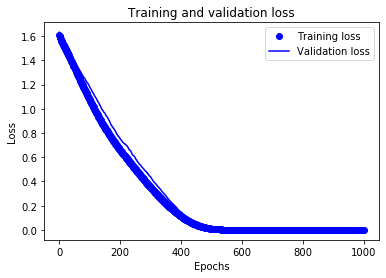

In [12]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

plotting accuracy
'accuracy', 'val_accuracy'

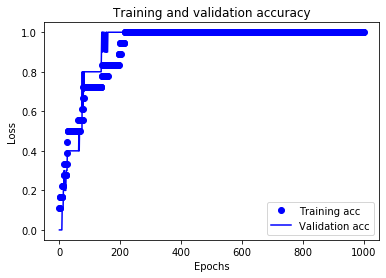

In [13]:
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']

plt.plot(epochs, acc_values, 'bo', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

## Making predictions using the model

First function to convert user text input to a bag of words to input to the model

In [14]:
def bag_of_words(s, words):
    bag = [0 for _ in range(len(words))]

    s_words = nltk.word_tokenize(s)
    s_words = [stemmer.stem(word.lower()) for word in s_words]

    for se in s_words:
        for i, w in enumerate(words):
            if w == se:
                bag[i] = 1
            
    return np.array(bag)

In [ ]:
Define chat function to start using the bot

In [15]:
def chat():
    print("Start talking with the bot (type quit to stop)!")
    while True:
        inp = input("You: ")
        if inp.lower() == "quit":
            break
        
        BoW = bag_of_words(inp, words)
        BoW = BoW[np.newaxis] 
        results = model.predict(BoW)
        results_index = np.argmax(results)
        tag = labels[results_index]

        for tg in fileData["intents"]:
            if tg['tag'] == tag:
                responses = tg['responses']

        print(random.choice(responses))

In [17]:
chat()

Start talking with the bot (type quit to stop)!
You: Bonjour, comment ca va? 
Bonjour! je suis bien!
You: quit
